In [13]:
import csv
from lazypredict.Supervised import LazyClassifier
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.preprocessing import LabelEncoder

In [14]:
# Load data
X = pd.read_csv('train_values.csv')[:28955]
Y = pd.read_csv('train_labels.csv')[:28955]
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Convert y_train and y_test to 1-dimensional arrays
y_train = y_train.values[:, 1]  # Select the first column
y_test = y_test.values[:, 1]    # Select the first column

In [15]:
models = ("RandomForestClassifier", "ExtraTreesClassifier", "ExtraTreeClassifier", "SVC")

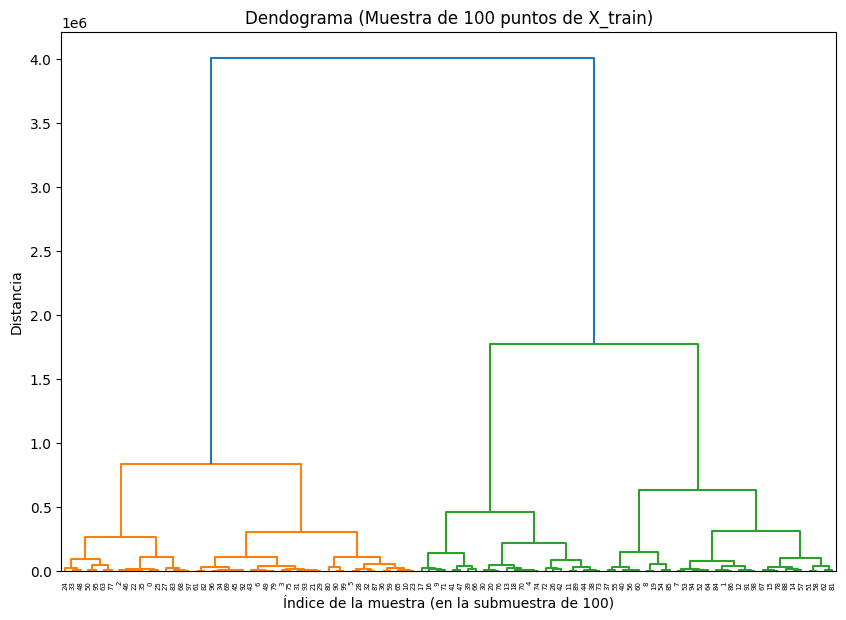

Formas de los datos listos para LazyClassifier:
X_train: (208480, 39)
X_test: (52121, 39)
y_train: (208480,)
y_test: (52121,)


In [16]:
# Celda 10 (Revisada)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split # Asegúrate de importar train_test_split aquí también

# Cargar datos COMPLETOS
X = pd.read_csv('train_values.csv')
Y = pd.read_csv('train_labels.csv')

# Hacer el split usando los datos completos
# Usar nombres diferentes para los DataFrames de y temporalmente
X_train, X_test, y_train_df, y_test_df = train_test_split(X, Y, test_size=0.2, random_state=42)

# Convertir columnas categóricas a numéricas en X
label_encoders = {}
categorical_cols = X_train.select_dtypes(include=['object']).columns
# Crear copias explícitas para evitar modificar los DataFrames originales si es necesario
X_train = X_train.copy()
X_test = X_test.copy()
for column in categorical_cols:
    le = LabelEncoder()
    # Ajustar y transformar en train, solo transformar en test
    X_train[column] = le.fit_transform(X_train[column])
    X_test[column] = le.transform(X_test[column])
    label_encoders[column] = le

# Extraer la columna target de y (asumiendo que es la segunda columna 'damage_grade')
# Verifica el nombre correcto de la columna en tu archivo train_labels.csv
target_column_name = Y.columns[1] # O escribe directamente 'damage_grade'
y_train = y_train_df[target_column_name].values
y_test = y_test_df[target_column_name].values

# --- Código del Dendrograma (sin cambios) ---
# Generar datos de ejemplo para el dendograma (usando el X_train ya codificado)
# Usar una muestra pequeña para el dendrograma para evitar lentitud/problemas visuales
if len(X_train) >= 100:
    data_dendrogram = X_train[:100]
else:
    data_dendrogram = X_train

# Realizar el linkage
# Considera usar StandardScaler antes del linkage si las escalas varían mucho
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# data_dendrogram_scaled = scaler.fit_transform(data_dendrogram)
# Z = linkage(data_dendrogram_scaled, method='ward')
Z = linkage(data_dendrogram, method='ward')


# Crear el dendograma
plt.figure(figsize=(10, 7))
plt.title("Dendograma (Muestra de 100 puntos de X_train)")
dendrogram(Z)
plt.xlabel("Índice de la muestra (en la submuestra de 100)")
plt.ylabel("Distancia")
plt.show()

# --- Fin Código del Dendrograma ---

# Ahora X_train, X_test (codificados) y y_train, y_test (arrays 1D)
# están definidos consistentemente basados en el split de los datos completos.
# La Celda 11 debería ahora usar datos con dimensiones consistentes.
print("Formas de los datos listos para LazyClassifier:")
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)


In [17]:
clf = LazyClassifier(verbose=1, ignore_warnings=True, custom_metric=None)

#Vamos a usar una porción de los datasets para evitar problemas de memoria
models, predictions = clf.fit(X_train[:len(X_train)//2], X_test[:len(X_test)//2], y_train[:len(y_train)//2], y_test[:len(y_test)//2])
models

ImportError: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html